In [1]:
# Setup: Pull latest code and install package with CUDA support
# Run this cell first. If imports fail, restart kernel and run again.

import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

# Detect environment and set repo path
if os.path.exists("/content"):  # Google Colab
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):  # Lambda Labs / similar
    REPO_DIR = "/workspace/FormationHNCA"
else:
    REPO_DIR = os.path.expanduser("~/FormationHNCA")

# Clone or pull latest
if os.path.exists(REPO_DIR):
    print(f"Pulling latest changes in {REPO_DIR}...")
    result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
    print(result.stdout or "Already up to date.")
else:
    print(f"Cloning repository to {REPO_DIR}...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install JAX with CUDA support (for H100/GPU)
print("Installing JAX with CUDA support...")
subprocess.run([
    sys.executable, "-m", "pip", "install", "-q",
    "jax[cuda12]"
], check=True)

# Install package
print("Installing battle-nca package...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)

# Add src to path as fallback
src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package...

Working directory: /workspace/FormationHNCA
Setup complete!


# Battle NCA Evaluation

This notebook provides comprehensive evaluation of trained Battle NCA models, including:
- Formation quality metrics (MSE, IoU, coverage)
- Stability analysis (temporal variance, convergence)
- Combat effectiveness metrics
- Regeneration capability testing

In [2]:
# Core imports
import sys
sys.path.insert(0, 'src')

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

# Battle NCA imports
from battle_nca.hierarchy import ChildNCA
from battle_nca.hierarchy.child_nca import create_army_seed, CHILD_CHANNELS
from battle_nca.combat import FormationTargets, rotate_formation
from battle_nca.combat.formations import FormationTypes, measure_formation_quality
from battle_nca.utils.metrics import (
    compute_army_statistics,
    compute_formation_metrics,
    compute_trajectory_metrics,
    compute_stability_metrics,
    print_battle_summary
)
from battle_nca.utils.visualization import (
    render_state,
    visualize_channels,
    plot_training_curves
)

print(f"JAX devices: {jax.devices()}")

JAX devices: [CudaDevice(id=0)]


## Load Trained Model

In [3]:
# Load checkpoint
checkpoint_path = Path('checkpoints/battle_nca_trained.pkl')

if checkpoint_path.exists():
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
    
    params = checkpoint['params']
    model_config = checkpoint['config']
    metrics = checkpoint.get('metrics', {})
    
    # Check if goal-conditioned
    goal_conditioned = model_config.get('goal_conditioned', False)
    formation_names = model_config.get('formation_names', ['line', 'phalanx', 'square', 'wedge', 'column'])
    num_formations = model_config.get('num_formations', len(formation_names))
    
    print("Loaded trained model")
    print(f"  Grid size: {model_config['grid_size']}")
    print(f"  Channels: {model_config['num_channels']}")
    print(f"  Goal-conditioned: {goal_conditioned}")
    if goal_conditioned:
        print(f"  Formations: {formation_names}")
else:
    print("No checkpoint found. Please run 01_training.ipynb first.")
    print("Creating untrained model for demonstration...")
    
    model_config = {
        'grid_size': 64,
        'num_channels': 24,
        'hidden_dim': 128
    }
    goal_conditioned = False
    formation_names = ['line', 'phalanx', 'square', 'wedge', 'column']
    num_formations = len(formation_names)
    
    # Initialize fresh model
    child_nca = ChildNCA(
        num_channels=model_config['num_channels'],
        hidden_dim=model_config['hidden_dim']
    )
    
    seed = create_army_seed(
        model_config['grid_size'],
        model_config['grid_size']
    )
    
    variables = child_nca.init(
        jax.random.PRNGKey(0),
        seed,
        jax.random.PRNGKey(1)
    )
    params = variables['params']
    metrics = None

Loaded trained model
  Grid size: 64
  Channels: 24
  Goal-conditioned: True
  Formations: ['line', 'phalanx', 'square', 'wedge', 'column']


In [4]:
# Create model instance
GRID_SIZE = model_config['grid_size']
NUM_CHANNELS = model_config['num_channels']

child_nca = ChildNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=model_config['hidden_dim'],
    fire_rate=0.5
)

# Create seed
seed = create_army_seed(
    GRID_SIZE, GRID_SIZE,
    team_color=(1.0, 0.0, 0.0),
    spawn_region=(GRID_SIZE//2-2, GRID_SIZE//2+2, GRID_SIZE//2-2, GRID_SIZE//2+2)
)

# Create targets
targets = {
    'line': FormationTargets.line(GRID_SIZE, GRID_SIZE),
    'phalanx': FormationTargets.phalanx(GRID_SIZE, GRID_SIZE, depth=8),
    'square': FormationTargets.square(GRID_SIZE, GRID_SIZE),
    'wedge': FormationTargets.wedge(GRID_SIZE, GRID_SIZE),
    'column': FormationTargets.column(GRID_SIZE, GRID_SIZE, col_width=4),
}

# Goal-conditioning signal helper
def create_formation_signal(height, width, formation_idx, angle=0.0, num_formations=5):
    """Create goal-conditioning signal for formation type + angle."""
    formation_val = (formation_idx / (num_formations - 1)) * 2 - 1
    angle_val = (angle / jnp.pi) - 1
    signal = jnp.zeros((height, width, 2))
    signal = signal.at[..., 0].set(formation_val)
    signal = signal.at[..., 1].set(angle_val)
    return signal

print(f"Goal-conditioned model: {goal_conditioned}")
print(f"Available formations: {list(targets.keys())}")

Goal-conditioned model: True
Available formations: ['line', 'phalanx', 'square', 'wedge', 'column']


## Formation Quality Evaluation

In [5]:
# Run model forward with goal conditioning support
key = jax.random.PRNGKey(42)

def run_model(state, params, key, num_steps=100, formation_idx=0, angle=0.0):
    """Run model forward for num_steps with optional goal conditioning.
    
    The formation signal is written into state channels 11-12 so cells can
    perceive it through their neighbors.
    """
    trajectory = [state]
    
    # Create formation signal if goal-conditioned
    if goal_conditioned:
        signal = create_formation_signal(GRID_SIZE, GRID_SIZE, formation_idx, angle, num_formations)
    else:
        signal = None
    
    for i in range(num_steps):
        key, subkey = jax.random.split(key)
        
        # Write signal into state channels before step
        if signal is not None:
            state = state.at[..., 11:13].set(signal)
        
        state = child_nca.apply({'params': params}, state, subkey, parent_signal=signal)
        trajectory.append(state)
    
    return jnp.stack(trajectory)

# Run forward for line formation (index 0)
trajectory = run_model(seed, params, key, num_steps=100, formation_idx=0, angle=0.0)
print(f"Trajectory shape: {trajectory.shape}")
print(f"Testing formation: line (idx=0, angle=0°)")

Trajectory shape: (101, 64, 64, 24)
Testing formation: line (idx=0, angle=0°)


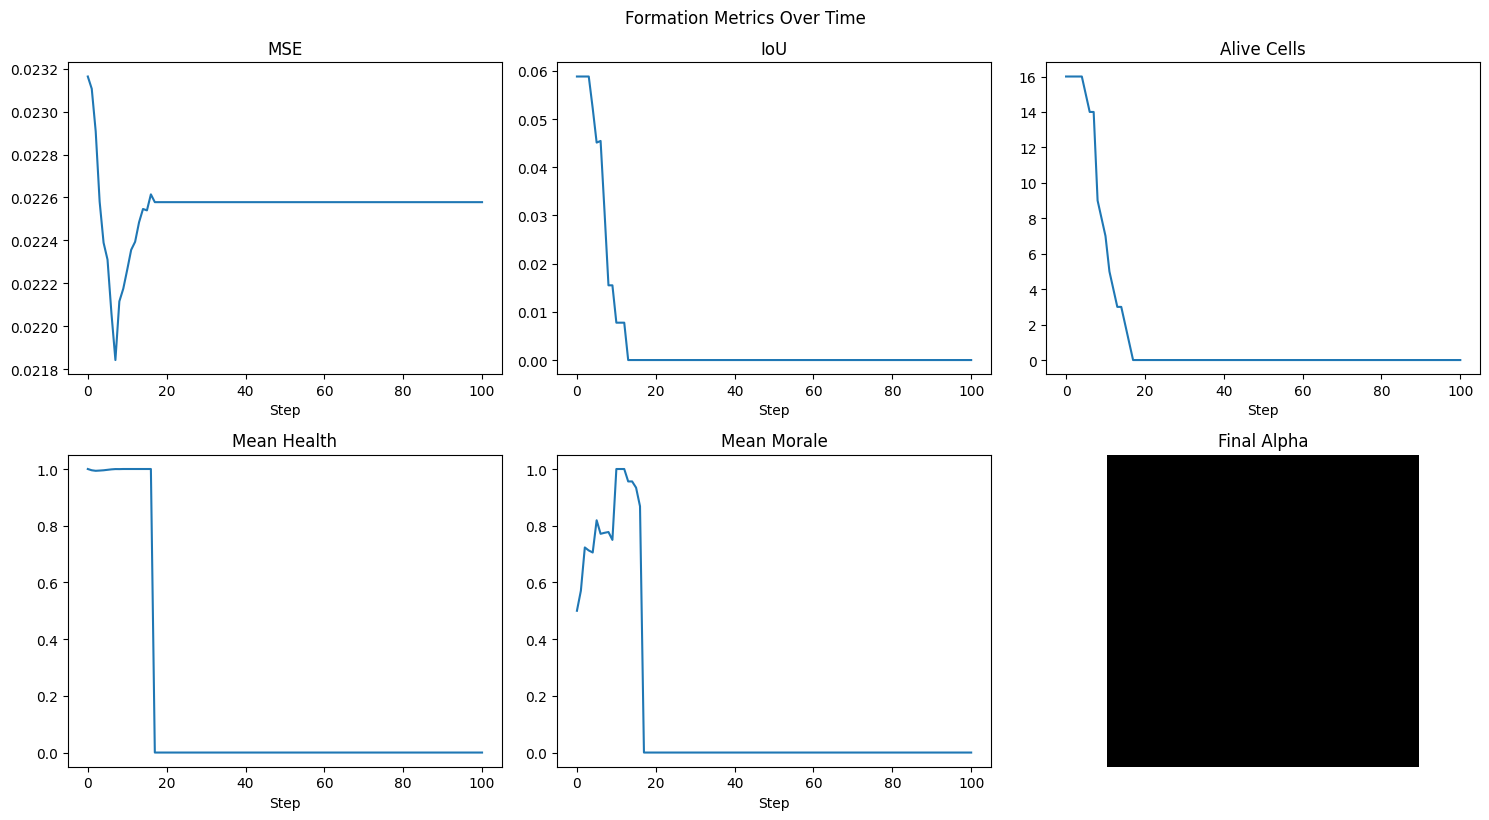

In [6]:
# Compute metrics over trajectory for line formation
target = targets['line']
traj_metrics = compute_trajectory_metrics(trajectory, target)

# Plot metrics over time
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].plot(traj_metrics['mse'])
axes[0, 0].set_title('MSE')
axes[0, 0].set_xlabel('Step')

axes[0, 1].plot(traj_metrics['iou'])
axes[0, 1].set_title('IoU')
axes[0, 1].set_xlabel('Step')

axes[0, 2].plot(traj_metrics['alive_cells'])
axes[0, 2].set_title('Alive Cells')
axes[0, 2].set_xlabel('Step')

axes[1, 0].plot(traj_metrics['mean_health'])
axes[1, 0].set_title('Mean Health')
axes[1, 0].set_xlabel('Step')

axes[1, 1].plot(traj_metrics['mean_morale'])
axes[1, 1].set_title('Mean Morale')
axes[1, 1].set_xlabel('Step')

# Final state comparison
axes[1, 2].imshow(trajectory[-1, ..., 3], cmap='gray')
axes[1, 2].set_title('Final Alpha')
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle('Formation Metrics Over Time', y=1.02)
plt.show()

In [7]:
# Compute formation metrics for all targets (with proper goal signal)
print("Formation Quality Metrics")
print("=" * 60)

formation_name_list = list(targets.keys())

for i, name in enumerate(formation_name_list):
    target = targets[name]
    
    # Run model with correct formation signal
    key, subkey = jax.random.split(key)
    traj = run_model(seed, params, subkey, num_steps=100, formation_idx=i, angle=0.0)
    final_state = traj[-1]
    
    metrics = compute_formation_metrics(final_state, target)
    
    signal_info = f" (signal={i})" if goal_conditioned else ""
    print(f"\n{name.upper()}{signal_info}:")
    print(f"  MSE: {metrics['mse']:.4f}")
    print(f"  IoU: {metrics['iou']:.4f}")
    print(f"  Coverage: {metrics['coverage']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}")

Formation Quality Metrics

LINE (signal=0):
  MSE: 0.0226
  IoU: 0.0000
  Coverage: 0.0000
  Precision: 0.0000
  F1: 0.0000

PHALANX (signal=1):
  MSE: 0.1128
  IoU: 0.0000
  Coverage: 0.0000
  Precision: 0.0000
  F1: 0.0000

SQUARE (signal=2):
  MSE: 0.1898
  IoU: 0.0000
  Coverage: 0.0000
  Precision: 0.0000
  F1: 0.0000

WEDGE (signal=3):
  MSE: 0.1450
  IoU: 0.0000
  Coverage: 0.0000
  Precision: 0.0000
  F1: 0.0000

COLUMN (signal=4):
  MSE: 0.0352
  IoU: 0.0000
  Coverage: 0.0000
  Precision: 0.0000
  F1: 0.0000


## Stability Analysis

In [8]:
# Run for longer to test stability
key = jax.random.PRNGKey(123)
long_trajectory = run_model(seed, params, key, num_steps=200, formation_idx=0, angle=0.0)

# Compute stability metrics
stability = compute_stability_metrics(long_trajectory, targets['line'], window=30)

print("Stability Metrics (Line Formation)")
print("=" * 50)
print(f"Temporal variance: {stability['temporal_variance']:.6f}")
print(f"Mean final loss: {stability['mean_final_loss']:.6f}")
print(f"Loss variance: {stability['loss_variance']:.6f}")
print(f"Convergence ratio: {stability['convergence_ratio']:.4f}")
print(f"  (< 1 = converging, > 1 = diverging)")

Stability Metrics (Line Formation)
Temporal variance: 0.000000
Mean final loss: 0.022578
Loss variance: 0.000000
Convergence ratio: 0.9884
  (< 1 = converging, > 1 = diverging)


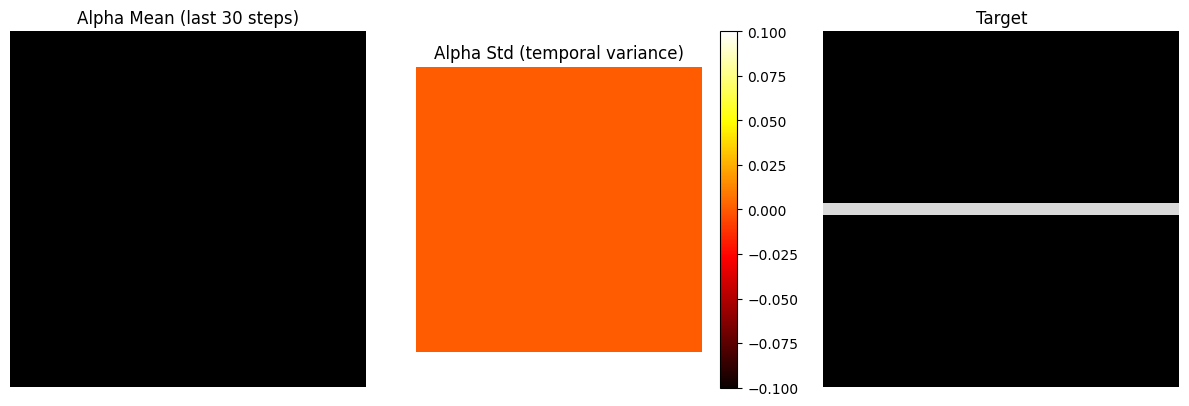

In [9]:
# Visualize stability: show variance in final 30 steps
final_30 = long_trajectory[-30:]
alpha_mean = np.mean(final_30[..., 3], axis=0)
alpha_std = np.std(final_30[..., 3], axis=0)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(alpha_mean, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Alpha Mean (last 30 steps)')
axes[0].axis('off')

axes[1].imshow(alpha_std, cmap='hot')
axes[1].set_title('Alpha Std (temporal variance)')
axes[1].axis('off')
plt.colorbar(axes[1].images[0], ax=axes[1])

axes[2].imshow(targets['line'][..., 3], cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Target')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Regeneration Testing

Test the model's ability to recover from damage.

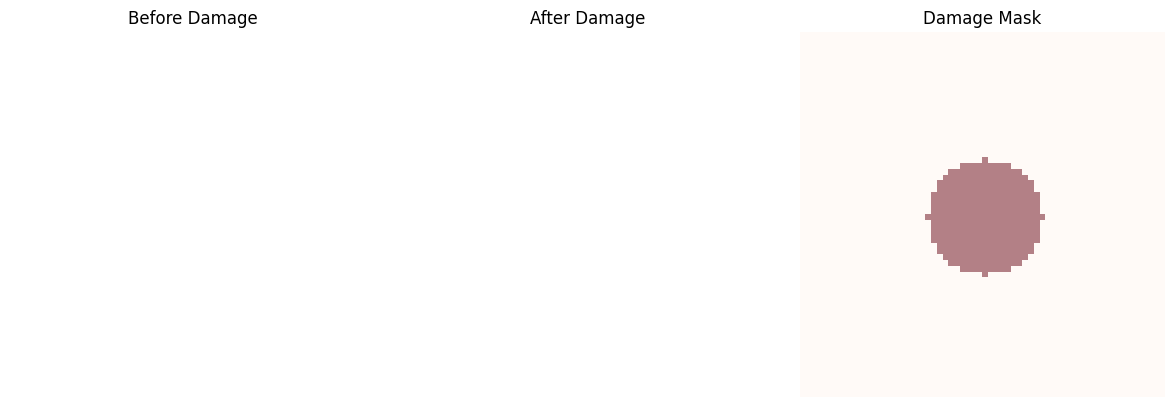

In [10]:
# First, grow to formation (with goal signal)
key = jax.random.PRNGKey(456)
grown_trajectory = run_model(seed, params, key, num_steps=80, formation_idx=0, angle=0.0)
grown_state = grown_trajectory[-1]

# Apply damage
damaged_state = np.array(grown_state.copy())

# Create circular damage
cy, cx = GRID_SIZE // 2, GRID_SIZE // 2
radius = 10
y, x = np.ogrid[:GRID_SIZE, :GRID_SIZE]
mask = (x - cx)**2 + (y - cy)**2 <= radius**2

damaged_state[mask] = 0.0
damaged_state = jnp.array(damaged_state)

# Visualize damage
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(np.clip(grown_state[..., :4], 0, 1))
axes[0].set_title('Before Damage')
axes[0].axis('off')

axes[1].imshow(np.clip(damaged_state[..., :4], 0, 1))
axes[1].set_title('After Damage')
axes[1].axis('off')

axes[2].imshow(mask, cmap='Reds', alpha=0.5)
axes[2].set_title('Damage Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

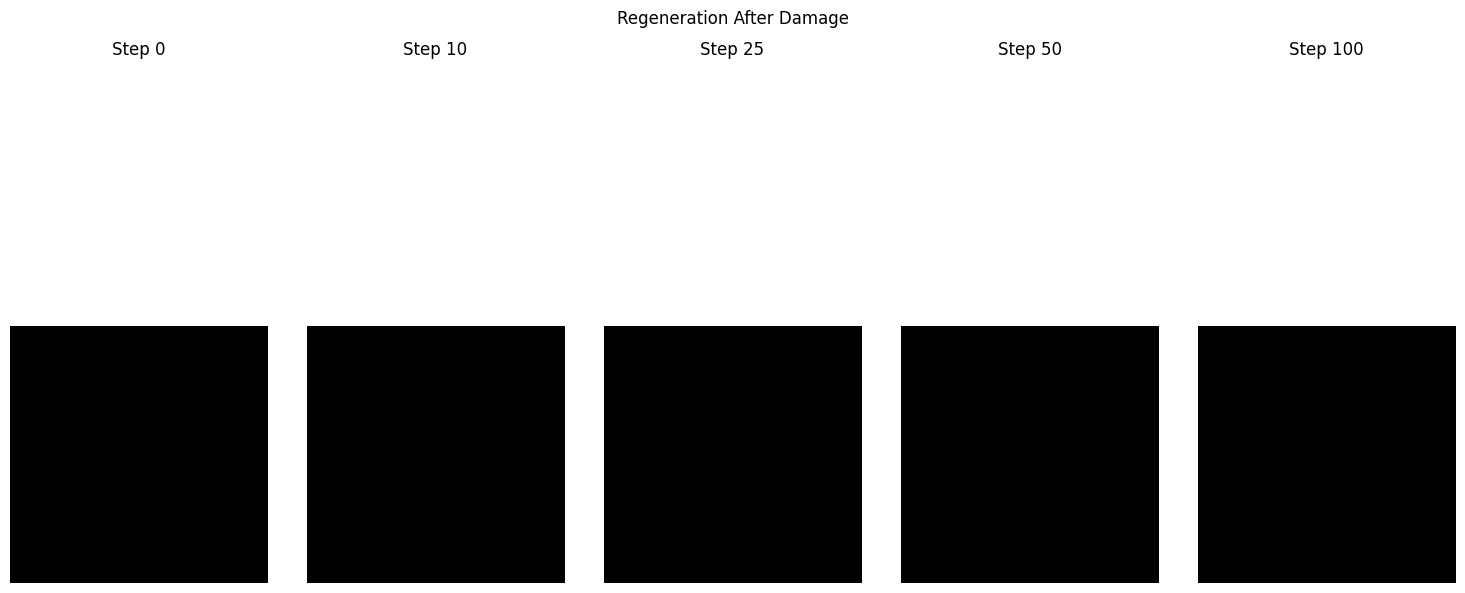

In [11]:
# Run recovery with goal signal
key, subkey = jax.random.split(key)

# Create signal for recovery
if goal_conditioned:
    signal = create_formation_signal(GRID_SIZE, GRID_SIZE, 0, 0.0, num_formations)  # line
else:
    signal = None

# Manual recovery loop (since we're starting from damaged state)
recovery_states = [damaged_state]
state = damaged_state
for i in range(100):
    key, subkey = jax.random.split(key)
    state = child_nca.apply({'params': params}, state, subkey, parent_signal=signal)
    recovery_states.append(state)

recovery_trajectory = jnp.stack(recovery_states)

# Compute metrics during recovery
recovery_metrics = compute_trajectory_metrics(recovery_trajectory, targets['line'])

# Plot recovery
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

steps_to_show = [0, 10, 25, 50, 100]

for i, step in enumerate(steps_to_show):
    # RGBA
    axes[0, i].imshow(np.clip(recovery_trajectory[step, ..., :4], 0, 1))
    axes[0, i].set_title(f'Step {step}')
    axes[0, i].axis('off')
    
    # Alpha
    axes[1, i].imshow(recovery_trajectory[step, ..., 3], cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('RGBA')
axes[1, 0].set_ylabel('Alpha')

plt.suptitle('Regeneration After Damage')
plt.tight_layout()
plt.show()

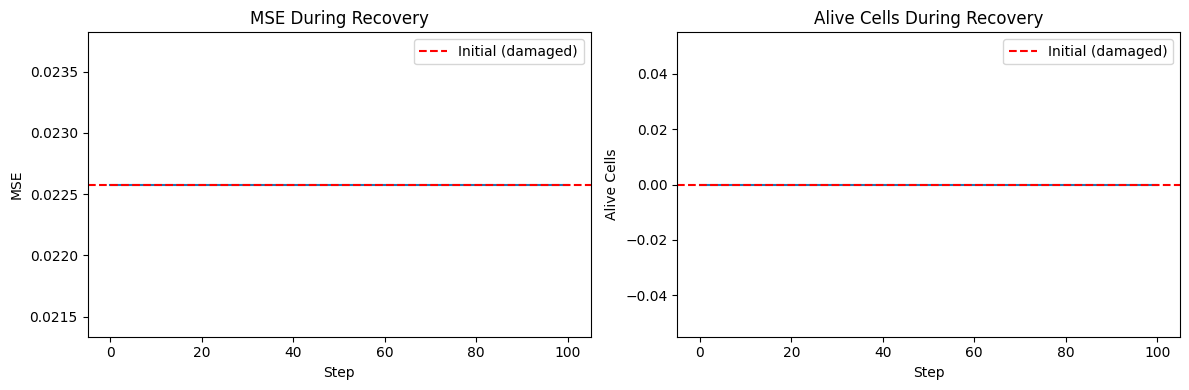


Recovery Statistics:
  Initial MSE: 0.0226
  Final MSE: 0.0226
  Recovery: 0.0%


In [12]:
# Plot recovery metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(recovery_metrics['mse'])
axes[0].set_title('MSE During Recovery')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=recovery_metrics['mse'][0], color='r', linestyle='--', 
                label='Initial (damaged)')
axes[0].legend()

axes[1].plot(recovery_metrics['alive_cells'])
axes[1].set_title('Alive Cells During Recovery')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Alive Cells')
axes[1].axhline(y=recovery_metrics['alive_cells'][0], color='r', linestyle='--',
                label='Initial (damaged)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Recovery statistics
initial_mse = recovery_metrics['mse'][0]
final_mse = recovery_metrics['mse'][-1]
recovery_rate = (initial_mse - final_mse) / initial_mse * 100

print(f"\nRecovery Statistics:")
print(f"  Initial MSE: {initial_mse:.4f}")
print(f"  Final MSE: {final_mse:.4f}")
print(f"  Recovery: {recovery_rate:.1f}%")

## Channel Analysis

Testing all formations with goal signals...


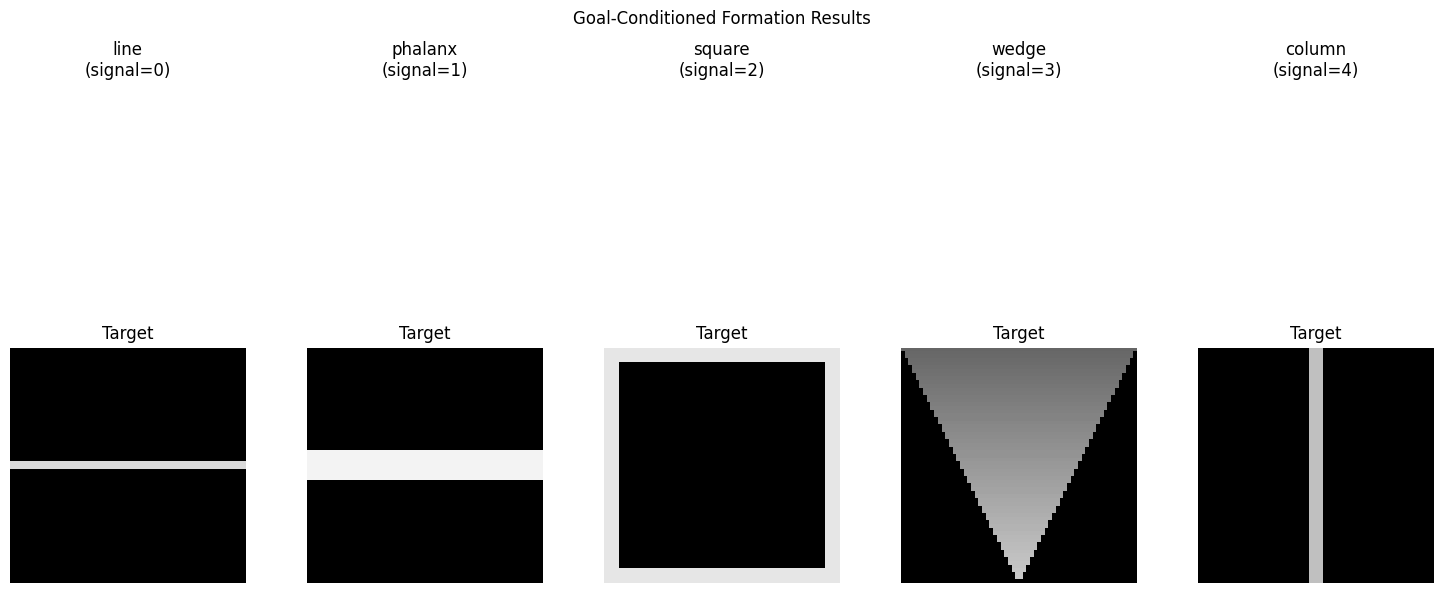

In [13]:
# Multi-formation evaluation (if goal-conditioned)
if goal_conditioned:
    print("Testing all formations with goal signals...")
    fig, axes = plt.subplots(2, len(targets), figsize=(15, 6))
    
    formation_name_list = list(targets.keys())
    
    for i, name in enumerate(formation_name_list):
        target = targets[name]
        
        # Run with correct formation signal
        key, subkey = jax.random.split(key)
        traj = run_model(seed, params, subkey, num_steps=100, formation_idx=i, angle=0.0)
        final = traj[-1]
        
        # Show result
        axes[0, i].imshow(np.clip(final[..., :4], 0, 1))
        axes[0, i].set_title(f'{name}\n(signal={i})')
        axes[0, i].axis('off')
        
        # Show target
        axes[1, i].imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title('Target')
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Result')
    axes[1, 0].set_ylabel('Target')
    
    plt.suptitle('Goal-Conditioned Formation Results')
    plt.tight_layout()
    plt.show()
else:
    print("Model is not goal-conditioned, skipping multi-formation test")

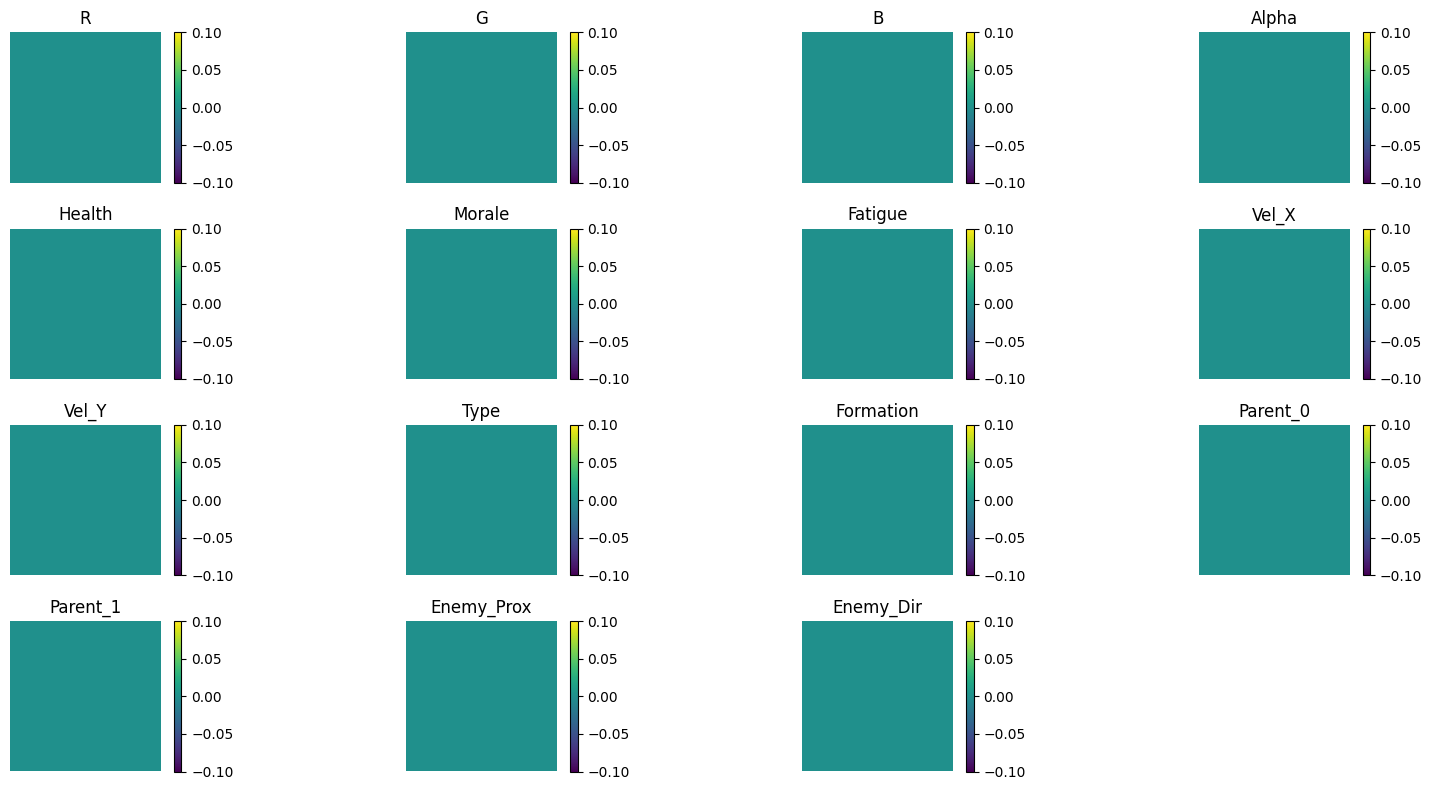

In [14]:
# Visualize all channels of final state
visualize_channels(
    long_trajectory[-1],
    channels=list(range(15)),  # First 15 channels
    show=True
)

In [15]:
# Army statistics
stats = compute_army_statistics(long_trajectory[-1])

print("Army Statistics (Final State)")
print("=" * 40)
print(f"Total units: {stats.total_units}")
print(f"Alive units: {stats.alive_units}")
print(f"Average health: {stats.average_health:.2%}")
print(f"Average morale: {stats.average_morale:+.2f}")
print(f"Average fatigue: {stats.average_fatigue:.2%}")
print(f"Routing units: {stats.routing_units}")
print(f"Unit density: {stats.unit_density:.4f}")

Army Statistics (Final State)
Total units: 0
Alive units: 0
Average health: 0.00%
Average morale: +0.00
Average fatigue: 0.00%
Routing units: 0
Unit density: 0.0000


## Summary

This notebook evaluated:
1. **Formation quality** - How well the NCA matches target formations
2. **Stability** - How consistent the pattern remains over time
3. **Regeneration** - How well the NCA recovers from damage
4. **Channel analysis** - Understanding internal state representations

**Key metrics to monitor:**
- IoU > 0.5 indicates good formation matching
- Temporal variance < 0.01 indicates stable attractors
- Convergence ratio < 0.5 indicates fast convergence

**Next steps:**
- See `03_visualization.ipynb` for animations and visual analysis